In [0]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
!tar -xzvf maps.tar.gz

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [0]:
transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=(256,256*2)),
    transforms.ToTensor(),
])

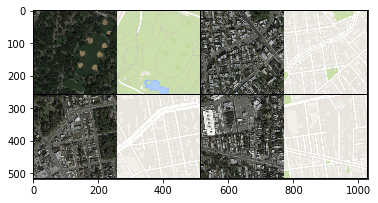

In [96]:
batch_size = 4
img_dir = "./maps/"

trainset = datasets.ImageFolder(root=img_dir, transform = transforms)
trainloader = torch.utils.data.DataLoader(trainset, 
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 2)

dataiter = iter(trainloader)
img, label = dataiter.next()
grid_img = torchvision.utils.make_grid(img, nrow=2)
plt.imshow(grid_img.permute(1, 2, 0))

In [0]:
def conv_block(in_channel, out_channel):
  model = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=3, stride = 1, padding=1),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(),
      
      nn.Conv2d(out_channel, out_channel, kernel_size=3, stride = 1, padding = 1),
      nn.BatchNorm2d(out_channel),
      nn.ReLU()
  )
  return model

# paper has upsample. But Transpose convolution achieves better accuracy than other methods
def conv_transpose_block(in_channel, out_channel):
  model = nn.Sequential(
      nn.ConvTranspose2d(in_channel, out_channel, kernel_size=3, stride = 2, padding = 1, output_padding=1),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(),
  )
  return model

# Image Segmentation using U-Net

![alt text](https://miro.medium.com/max/1400/1*OkUrpDD6I0FpugA_bbYBJQ.png)



In [98]:
class UNet(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(UNet, self).__init__()
    self.in_channel = in_channel
    self.out_channel = out_channel
    
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    #   In every downsampling layer the channels are doubled. 
    self.down_1 = conv_block(self.in_channel, 64)
    self.down_2 = conv_block(64, 64*2)
    self.down_3 = conv_block(64*2, 64*4)
    self.down_4 = conv_block(64*4, 64*8)
    
    self.bridge = conv_block(64 * 8, 64 * 16)
#   In the 2015 paper, upsample is used. But today Transposed Convolution achieves better accuracy than upsampling 
    self.trans_1 = conv_transpose_block(64 * 16, 64 * 8)
    self.upconv_1 = conv_block(64 * 16, 64 * 8)
    
    self.trans_2 = conv_transpose_block(64 * 8, 64 * 4)
    self.upconv_2 = conv_block(64 * 8, 64 * 4)
    
    self.trans_3 = conv_transpose_block(64 * 4, 64 * 2)
    self.upconv_3 = conv_block(64 * 4, 64 * 2)
    
    self.trans_4 = conv_transpose_block(64 * 2, 64 * 1)
    self.upconv_4 = conv_block(64 * 2, 64 * 1)
    
    self.final_conv = nn.Sequential(
        nn.Conv2d(64, self.out_channel, kernel_size=3, stride=1, padding = 1),
        nn.Sigmoid(),
    )
  
  def forward(self, x):
#     Downsampling path
    down_1 = self.down_1(x)
    pool_1 = self.pool(down_1)
    
    down_2 = self.down_2(pool_1)
    pool_2 = self.pool(down_2)
    
    down_3 = self.down_3(pool_2)
    pool_3 = self.pool(down_3)
    
    down_4 = self.down_4(pool_3)
    pool_4 = self.pool(down_4)
    
    bridge = self.bridge(pool_4)
    
#     Expansive path
#   According to paper, we copy the features of image. So tensor has [batch_size, channel, row, column]. That's why torch.cat(..,dim=1)
    trans_1 = self.trans_1(bridge)
    concat_1 = torch.cat([trans_1, down_4], dim=1)
    upconv_1 = self.upconv_1(concat_1)
    
    trans_2 = self.trans_2(upconv_1)
    concat_2 = torch.cat([trans_2, down_3], dim=1)
    upconv_2 = self.upconv_2(concat_2)
    
    trans_3 = self.trans_3(upconv_2)
    concat_3 = torch.cat([trans_3, down_2], dim=1)
    upconv_3 = self.upconv_3(concat_3)
    
    trans_4 = self.trans_4(upconv_3)
    concat_4 = torch.cat([trans_4, down_1], dim=1)
    upconv_4 = self.upconv_4(concat_4)
    
    out = self.final_conv(upconv_4)
    
    return out
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(3,3).to(device)
summary(model, img[0].size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 512]           1,792
       BatchNorm2d-2         [-1, 64, 256, 512]             128
              ReLU-3         [-1, 64, 256, 512]               0
            Conv2d-4         [-1, 64, 256, 512]          36,928
       BatchNorm2d-5         [-1, 64, 256, 512]             128
              ReLU-6         [-1, 64, 256, 512]               0
         MaxPool2d-7         [-1, 64, 128, 256]               0
            Conv2d-8        [-1, 128, 128, 256]          73,856
       BatchNorm2d-9        [-1, 128, 128, 256]             256
             ReLU-10        [-1, 128, 128, 256]               0
           Conv2d-11        [-1, 128, 128, 256]         147,584
      BatchNorm2d-12        [-1, 128, 128, 256]             256
             ReLU-13        [-1, 128, 128, 256]               0
        MaxPool2d-14         [-1, 128, 

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [0]:
EPOCHS = 50
print_every = 200

for epoch in range(EPOCHS):
  running_loss = 0.0
  
  for iters, (data,labels) in enumerate(trainloader, 0):
    satell_img, map_img = torch.chunk(data, chunks=2, dim=3)
    
    x = satell_img.to(device)
    y_ = map_img.to(device)
    
#     make gradients parameter zero   
    optimizer.zero_grad()

#    forward propagation
    output = model.forward(x)
#   calculate loss    
    loss = criterion(output, y_)
#   do backward propagation    
    loss.backward()
#   update weights    
    optimizer.step()
    
    running_loss += loss.item()
    
    if iters % print_every == 199:
      print("epoch: %d, iterations: %5d, loss: %.3f" % 
           (epoch + 1, iters + 1, running_loss / print_every))
      
      running_loss = 0.0
      
print("Finished Training")